Images reference:

https://www.researchgate.net/publication/304674552_Background_Oriented_Schlieren_BOS_of_a_Supersonic_Aircraft_in_Flight

Slides 23 & 25:
https://core.ac.uk/download/pdf/211015751.pdf

In [1]:
# Imports
import numpy as np

User-specified parameters

In [2]:
## User-params
denPts = 3  #No. of density samples for training
H = 1000 #No. of gradient samples for training
N = 50 #Grid dimensions for original grid and also used for testing grid (Xnew)
freestream_density = 0.459 #Standard atmospheric density at 9000 m altitude
                    #https://www.engineeringtoolbox.com/standard-atmosphere-d_604.html

In [3]:
subset = 10 #If uniform sampling for training, use this subset

Load images

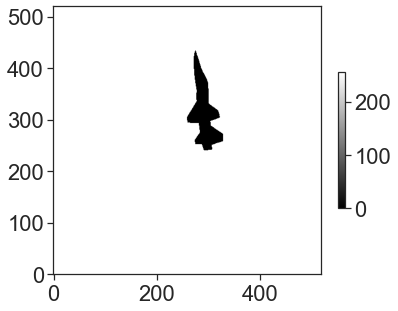

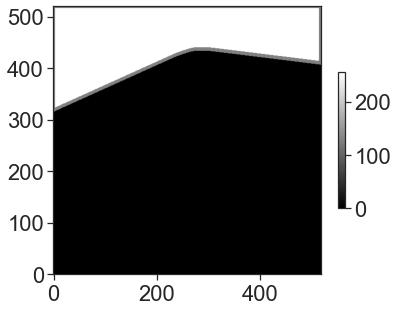

In [4]:
%load_ext autoreload
%autoreload 2
from Case3helper_redo import image

# Initialise case
case = image(randseed=1)

# Read in density and gradient images
case.read_images(N=N, denVal=freestream_density)

# Mask solid region
case.mask_geometry()

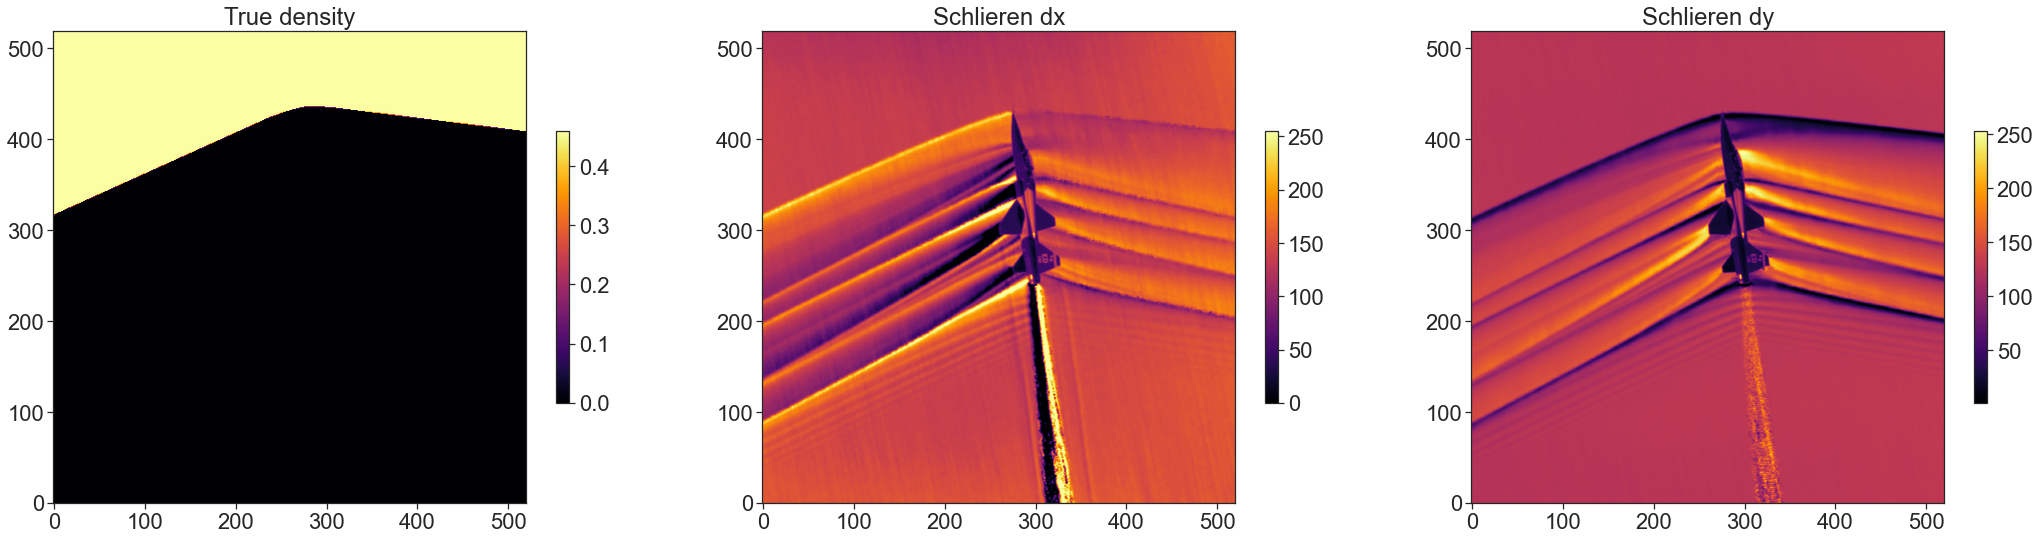

In [5]:
# Plot input density & pixel normalised gradients
case.plot_true_grads()

vals shape: (2704, 1)
Adding density points...
No. of training points:  2706
Indices: (520, 520) (520, 520)


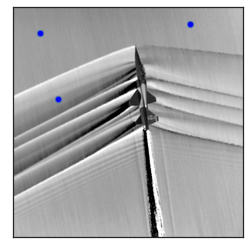

In [6]:
# # Get random density values automatically for training
# X_f, f = case.get_ran_density(npts=denPts)

# Manually specify density sampling coordinates
# Note, First column is x, second column is y
X_f = np.array([
    [60, 460],  # Freestream
    # [200, 500],  # Freestream
    [400, 480], # Freestream
    [100, 310], # After first shock
    # [450, 360], # After first shock
])

# # Get nearest points from subsampled density image.
X_f, f = case.get_nearest(X_f)

case.X_f = X_f
case.f = f

f[2] = 0.5

Ms, us = case.gen_subsample_pts(step=subset, mask_geom=True)   # Subset sampling of original grid

# Generate grid for testing
case.gen_test_grid(step=subset)

case.plot_sampling_pts(savefile="exports/case4_sampling.jpg")

# Gradient Enhanced Kriging
__________________

# Using Gradient-Based Kriging (Input dx and dy)
___

In [7]:
import pymc3 as pm
import schlierenPymc3 as spm
import theano.tensor as tt

sigma_y, sigma_dy = 0.06, 1

with pm.Model() as model:

    # Define hyperparameters
    bx = by = c = 0.0

    ls = pm.HalfNormal("ls", sigma=1, shape=2)
    lamda = pm.HalfNormal("lamda", sigma=1, shape=2)

    alphas = tt.stack([lamda[0] * lamda[1]/tt.square(ls[0]) , \
                         lamda[1] * lamda[0]/tt.square(ls[1])])

    xi = pm.HalfNormal("xi", sigma=1)
    sigma_f =  tt.sqrt(xi/(lamda[0] * lamda[1]))

    data = np.r_[
                us[:, 0] - np.average(us[:, 0]),
                us[:, 1] - np.average(us[:, 1]),
                f.ravel() - np.average(f)
                ]

    print("No. of function values: ", len(X_f))
    print("No. of gradient values: ", len(Ms))
    print("Data length: ", len(data))

    mean_func = spm.gp.mean.SchlierenNorm(bx=bx, by=by, c=c)
    cov_gek = spm.gp.cov.NormGEK(input_dim=2, ls=ls, \
                                 sigma_f=sigma_f, alphas=alphas)
    gp = spm.gp.MarginalNormGEK(mean_func=mean_func, cov_func=cov_gek)
    y_ = gp.marginal_likelihood("y_",
                                X=X_f/case.scale,  #Function value locations
                                X_df=Ms/case.scale,  #Gradient value locations
                                y=data,
                                noise_y=sigma_y,    #Input function noise
                                noise_dy=sigma_dy)  #Input gradient noise

No. of function values:  3
No. of gradient values:  2706
Data length:  5415


In [8]:
# Inference
mu_s, cov_s = case.infer(model=model, gp=gp, method="map")


{'ls_log__': array([2.59850745, 2.61397754]), 'lamda_log__': array([3.87095534, 3.87095534]), 'xi_log__': array(3.87040579), 'ls': array([13.44365766, 13.6532494 ]), 'lamda': array([47.9882092, 47.9882092]), 'xi': array(47.96184439)}


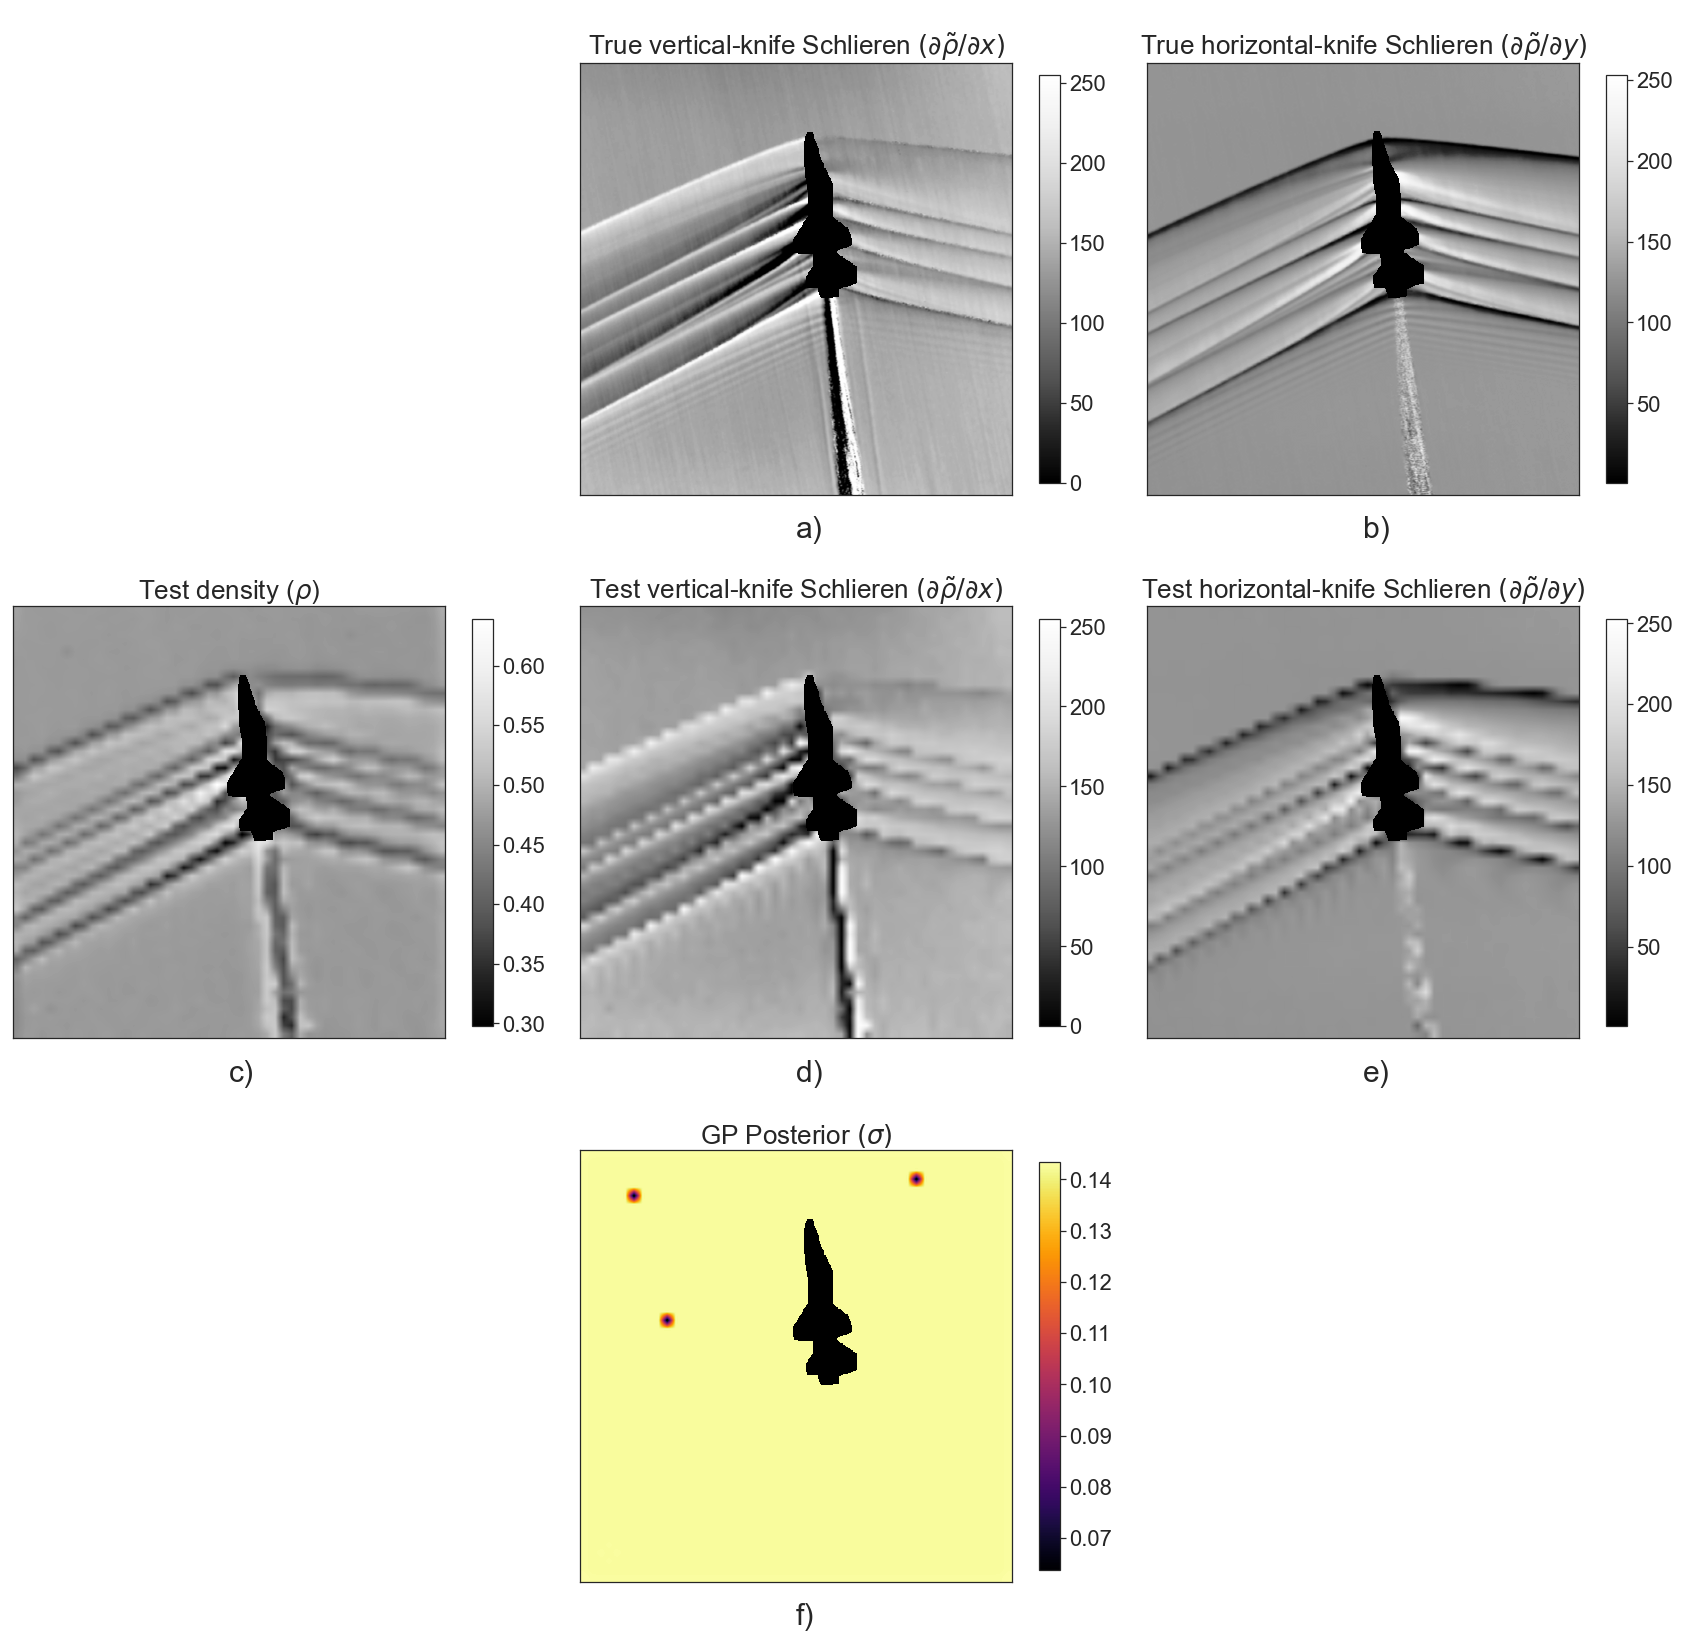

In [9]:
case.plot_posterior(savefile="exports/case3/prediction")

In [10]:
case.save_results(filepath="exports/case3/results.vtk")